# Toronto emotional speech set (TESS)

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

https://utoronto.scholaris.ca/collections/036db644-9790-4ed0-90cc-be1dfb8a4b66

OAF stands for "Older Adult Female". This refers to the actress aged 64 years.

YAF stands for "Younger Adult Female". This refers to the actress aged 26 years.

In [2]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt

## TESS Dataset

# Download dataset from Kaggle
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)
# List all files in the dataset
print(os.listdir(path))
# change name of existing folder on path
os.rename(os.path.join(path, os.listdir(path)[0]), os.path.join(path, "TESS"))

tess_path = os.path.join(path, "TESS")
print(os.listdir(tess_path))


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']


<Axes: title={'center': 'Emotion Distribution in TESS'}, xlabel='label'>

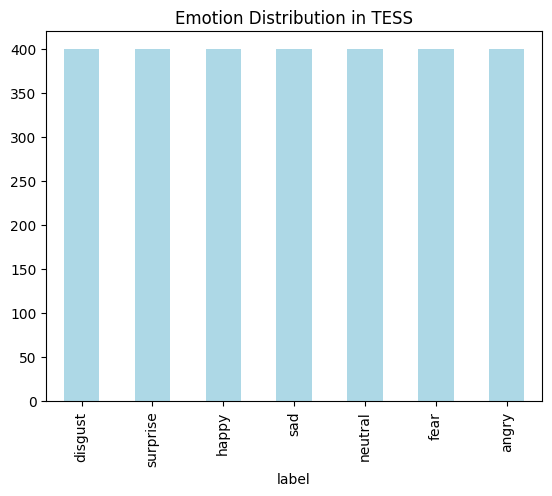

In [3]:
all_files = [
    os.path.join(tess_path, folder, filename)
    for folder in os.listdir(tess_path)
    for filename in os.listdir(os.path.join(tess_path, folder))
]

labels = [
    f[:-4].split('_')[-1].lower() 
    if f[:-4].split('_')[-1].lower() != "ps"
    else "surprise"
    for f in all_files
]

tess_db = pd.DataFrame({
    'filename': all_files,
    'label': labels
})

tess_db['label'].value_counts().plot(kind='bar', color='lightblue', title='Emotion Distribution in TESS')



In [4]:
import sys
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)

from src.recognizers import SpeechEmotionRecognizer
import librosa
from tqdm import tqdm
tqdm.pandas()



# Initialize the assistant
ser = SpeechEmotionRecognizer()
# Analyze the dataset
preds = []
for i in tqdm(range(len(tess_db))):
    filename = tess_db['filename'].iloc[i]
    audio, sr = librosa.load(filename, sr=16000)
    pred = ser.analyze(audio, sr)
    preds.append(pred['emotions'][0])
tess_db['pred'] = preds
tess_db.head()

2025-06-01 16:42:55.706819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 2800/2800 [04:34<00:00, 10.20it/s]


,filename,label,pred
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,boredom


              precision    recall  f1-score   support

       angry       0.27      0.04      0.07       400
     boredom       0.00      0.00      0.00         0
     disgust       0.17      0.59      0.27       400
        fear       0.00      0.00      0.00       400
       happy       0.45      0.03      0.06       400
     neutral       1.00      0.00      0.00       400
         sad       0.00      0.00      0.00       400

    accuracy                           0.11      2400
   macro avg       0.27      0.09      0.06      2400
weighted avg       0.31      0.11      0.07      2400



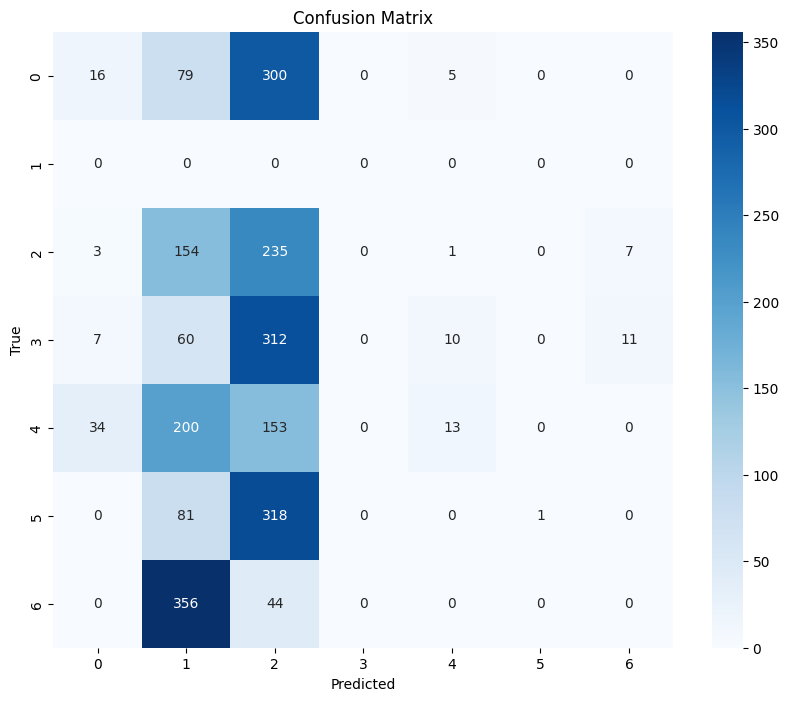

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fuse labels with similar meanings
tess_db['pred'] = tess_db['pred'].replace({
    'anger': 'angry',
    'happiness': 'happy',
    'sadness': 'sad',
    'fearful' : 'fear'
})

tess_db = tess_db[tess_db['label'].isin(['disgust', 'sad', 'boredom', 'angry', 'fear', 'happy', 'neutral'])]

# Generate a classification report
report = classification_report(tess_db['label'], tess_db['pred'])

print(report)
# Generate a confusion matrix
cm = confusion_matrix(tess_db['label'], tess_db['pred'])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=emo_order, yticklabels=emo_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:

print(tess_db["label"].unique())
print(tess_db['pred'].unique())

['disgust' 'happy' 'sad' 'neutral' 'fear' 'angry']
['disgust' 'boredom' 'sad' 'angry' 'happy' 'neutral']


# Librosa

In [7]:
import librosa
import numpy as np

def extract_ser_features(y, sr=16000, n_mfcc=13, frame_length=2048, hop_length=512):
    features = {}

    # 1. MFCCs + delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    delta_mfcc = librosa.feature.delta(mfcc)
    features['mfcc'] = mfcc
    features['delta_mfcc'] = delta_mfcc

    # 2. Chroma
    features['chroma'] = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)

    # 3. Mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['mel'] = librosa.power_to_db(mel)

    # 4. RMS energy
    features['rms'] = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)

    # 5. Zero Crossing Rate
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)

    # 6. Spectral features
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_contrast'] = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_flatness'] = librosa.feature.spectral_flatness(y=y, n_fft=frame_length, hop_length=hop_length)

    return features


def aggregate_features(features_dict):
    """Transforma features 2D em vetores 1D com média + desvio padrão."""
    agg_features = []
    for key, feat in features_dict.items():
        agg_features.append(np.mean(feat, axis=1))
        agg_features.append(np.std(feat, axis=1))
    return np.concatenate(agg_features)

def extract_audio_features(file_path):
    # Carregar arquivo de áudio
    y, sr = librosa.load(file_path, sr=16000)

    # Extrair features
    features = extract_ser_features(y, sr)
    X = aggregate_features(features)

    return X

#print("Shape do vetor final:", X.shape)  # pronto para SVM


In [8]:
import librosa
import numpy as np
from scipy.stats import skew, kurtosis


def extract_short_term_features(y, sr=16000, frame_length=2048, hop_length=512):
    features = {}
    
    # Temporal features
    features['zcr'] = librosa.feature.zero_crossing_rate(y, 
                        frame_length=frame_length, 
                        hop_length=hop_length)
    
    features['rms'] = librosa.feature.rms(y=y, 
                      frame_length=frame_length, 
                      hop_length=hop_length)
    
    # Spectral features
    S = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)
    S_magnitude = np.abs(S)
    features['spectral_centroid'] = librosa.feature.spectral_centroid(S=S_magnitude)
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(S=S_magnitude)
    features['spectral_contrast'] = librosa.feature.spectral_contrast(S=S_magnitude, sr=sr)
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(S=S_magnitude, sr=sr)
    
    # MFCCs
    features['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, 
                       n_mfcc=40,
                       n_fft=frame_length,
                       hop_length=hop_length)
    
    # Chroma
    features['chroma'] = librosa.feature.chroma_stft(y=y, sr=sr, 
                        n_fft=frame_length,
                        hop_length=hop_length)
    
    # Mel-scaled spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, 
                    n_fft=frame_length,
                    hop_length=hop_length)
    features['mel'] = librosa.power_to_db(mel)
    
    # Harmonic/percussive
    y_harm = librosa.effects.harmonic(y)
    y_perc = librosa.effects.percussive(y)
    features['harmonic'] = librosa.feature.rms(y=y_harm)
    features['percussive'] = librosa.feature.rms(y=y_perc)
    
    return features

def extract_long_term_features(y, sr=16000):
    features = {}
    
    # Short-term feature statistics
    st_features = extract_short_term_features(y, sr)
    
    # Aggregate statistics
    for name, vals in st_features.items():
        features[f'{name}_mean'] = np.mean(vals, axis=1)
        features[f'{name}_std'] = np.std(vals, axis=1)
        features[f'{name}_skew'] = skew(vals, axis=1)
        features[f'{name}_kurtosis'] = kurtosis(vals, axis=1)
    
    # Global features
    features['tempo'] = librosa.beat.tempo(y=y, sr=sr)[0]
    features['tempogram'] = librosa.feature.tempogram(y=y, sr=sr)
    features['spectral_flatness'] = librosa.feature.spectral_flatness(y=y)
    features['tonnetz'] = librosa.feature.tonnetz(y=y, sr=sr)
    features['poly_features'] = librosa.feature.poly_features(S=np.abs(librosa.stft(y)))
    
    return features


def flatten_features(features):
    return np.concatenate([v.flatten() for v in features.values()])

def extract(file):

    # Load audio
    y, sr = librosa.load(file, sr=16000)

    # Extract both feature types
    st_features = extract_short_term_features(y, sr)  # Returns dict of 2D arrays
    lt_features = extract_long_term_features(y, sr)   # Returns dict of 1D vectors

    # Convert to ML-ready format
    X_short_term = flatten_features(st_features)  # For sequence models (LSTM)
    X_long_term = flatten_features(lt_features)   # For static classifiers (SVM)

    return X_short_term, X_long_term
    





In [9]:
from tqdm import tqdm
tqdm.pandas()

df = pd.read_csv('TESS_EmoDB_RAVDESS.csv')

df.head()

,Unnamed: 0,filename,label,pred
0,0,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
1,1,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
2,2,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
3,3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
4,4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,boredom


In [21]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
sample = dataset[0]["audio"]

result = pipe(sample, return_timestamps=True)
print(result["text"])


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel. Nor is Mr. Quilter's manner less interesting than his matter. He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind. He has grave doubts whether Sir Frederick Leighton's work is really Greek after all, and can discover in it but little of rocky Ithaca. Linnell's pictures are a sort of Upguards and Adam paintings, and Mason's exquisite idylls are as national as a jingo poem. Mr. Burkett Foster's landscapes smile at one much in the same way that Mr. Carker used to flash his teeth. And Mr. John Collier gives his sitter a cheerful slap on the back before he says, like a shampooer in a Turkish bath, Next man!


The "mean MFCCs" always come with the same length because of two key factors in their calculation:

The n_mfcc parameter: This parameter directly specifies how many Mel-frequency cepstral coefficients you want to extract per frame. It's a fixed number that you define (e.g., 40 in your code). This means that for each individual frame of audio, you will get a vector of n_mfcc values.

librosa.feature.mfcc actually returns a 2D array with shape (n_mfcc, num_frames).
The first dimension (n_mfcc) represents the different cepstral coefficients. These capture various aspects of the spectral envelope (the "timbre" or "quality" of the sound). You decide how many of these you want to keep.
The second dimension (num_frames) represents time. It tells you how many short time windows (frames) were processed from the audio. As we discussed, this number does vary with the length of the audio file.
 The np.mean(..., axis=1) operation: This is the crucial step that collapses the time dimension (num_frames) into a single set of statistics.

When you apply np.mean(mfccs, axis=1) (or np.mean(mfccs.T, axis=0) which is equivalent to np.mean(mfccs, axis=1) if mfccs is (n_mfcc, num_frames)), you are calculating the average value for each of the n_mfcc coefficients across all the num_frames of the audio file.
Think of it like this: If you have a matrix where rows are coefficients and columns are frames, axis=1 tells NumPy to calculate the mean along the columns. This means for each row (each coefficient), you get one mean value.
So, regardless of whether your audio file was 1 second long (e.g., 94 frames) or 10 seconds long (e.g., 940 frames), if you calculate the mean across the time axis, you will still end up with n_mfcc mean values.

In [60]:
#X_short_long = df['filename'].progress_apply(extract)

def extract_features(file_path, n_mfcc=40):
    # Load the audio file
    y, sr = librosa.load(file_path)#, duration=3, offset=0.5)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Take the mean of the MFCCs across time to get a fixed-length feature vector
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

X_short_long = df['filename'].progress_apply(extract_features)


100%|██████████| 4375/4375 [00:54<00:00, 79.85it/s] 


In [10]:
df['X'] = df['filename'].progress_apply(extract_audio_features)
df.head()

100%|██████████| 4375/4375 [04:10<00:00, 17.48it/s]


,Unnamed: 0,filename,label,pred,X
0,0,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[-408.68035888671875, 46.382110595703125, 8.89..."
1,1,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[-360.78594970703125, 71.96761322021484, -11.1..."
2,2,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[-392.22613525390625, 59.31275177001953, 6.190..."
3,3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[-409.1956481933594, 38.50605010986328, 7.9133..."
4,4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,boredom,"[-392.86077880859375, 80.93343353271484, 5.749..."


(3062, 358)
Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.86      0.92      0.89       216
     boredom       0.70      0.96      0.81        24
        calm       0.64      0.74      0.69        58
     disgust       0.82      0.79      0.80       191
        fear       0.87      0.89      0.88       198
       happy       0.82      0.76      0.79       199
     neutral       0.83      0.87      0.85       173
         sad       0.81      0.70      0.75       196
    surprise       0.70      0.72      0.71        58

    accuracy                           0.82      1313
   macro avg       0.78      0.82      0.80      1313
weighted avg       0.82      0.82      0.82      1313



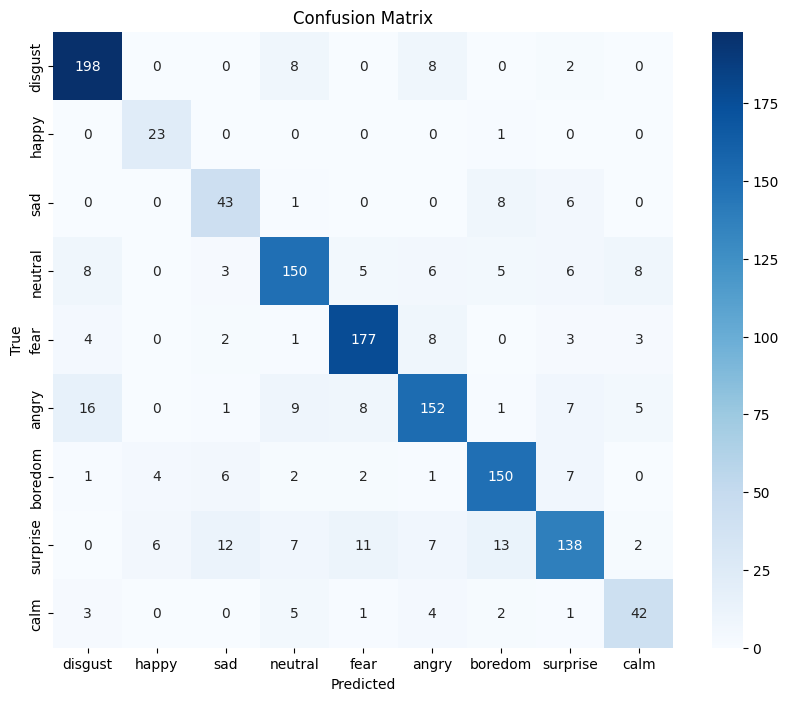

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split e treino
y = df['label']
X = np.array([np.array(i) for i in df['X'].to_list()])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(X_train.shape)

## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
clf12 = SVC(kernel='linear')
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [81]:
# Create a test dataframe for filenames and labels
X_df = df[['filename', 'label']].copy()
X_train_df, X_test_df = train_test_split(X_df, test_size=0.2, random_state=42, stratify=X_df['label'])

# Reset indices to align with prediction outputs
X_test_df = X_test_df.reset_index(drop=True)
y_test = X_test_df['label'].reset_index(drop=True)
filenames_test = X_test_df['filename'].reset_index(drop=True)

# Predict again if needed
pred_test = pd.Series(pred12, index=y_test.index)
pred_test

0      surprise
1           sad
2         angry
3          fear
4          fear
         ...   
870     neutral
871        fear
872         sad
873       happy
874     disgust
Length: 875, dtype: object


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/16b10Aa.wav
❌ Predicted: sad | ✅ True: fear


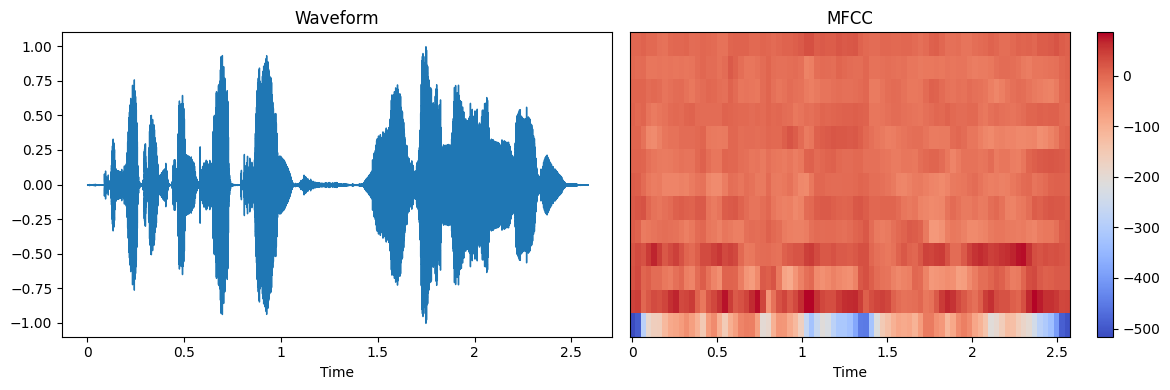


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/16a02Ea.wav
❌ Predicted: angry | ✅ True: disgust


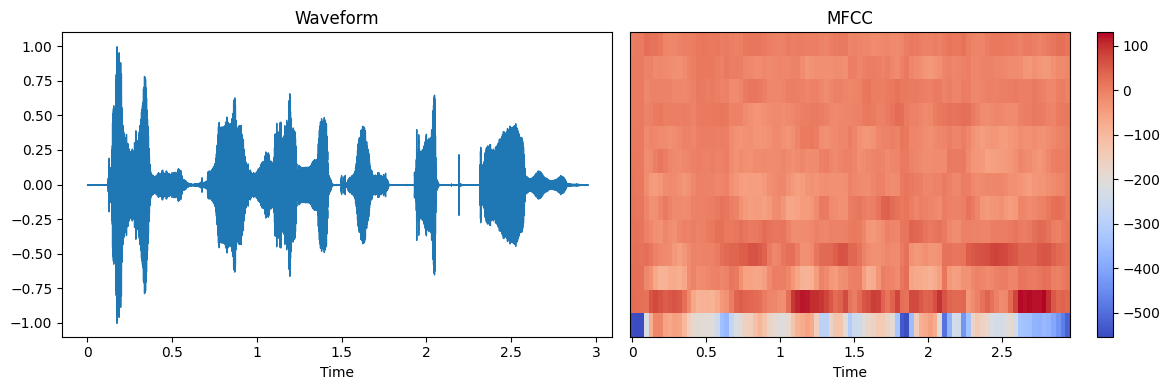


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/OAF_neutral/OAF_late_neutral.wav
❌ Predicted: fear | ✅ True: neutral


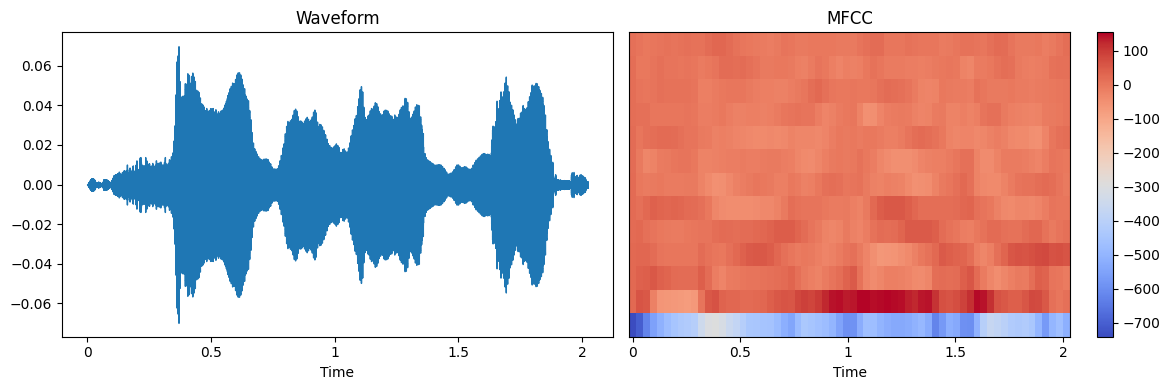


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/11a05Wd.wav
❌ Predicted: fear | ✅ True: angry


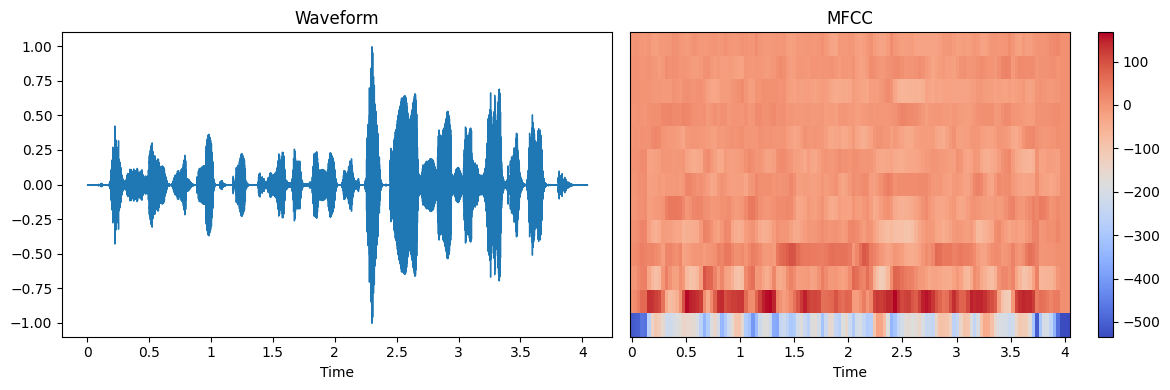


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/09b03Fd.wav
❌ Predicted: calm | ✅ True: happy


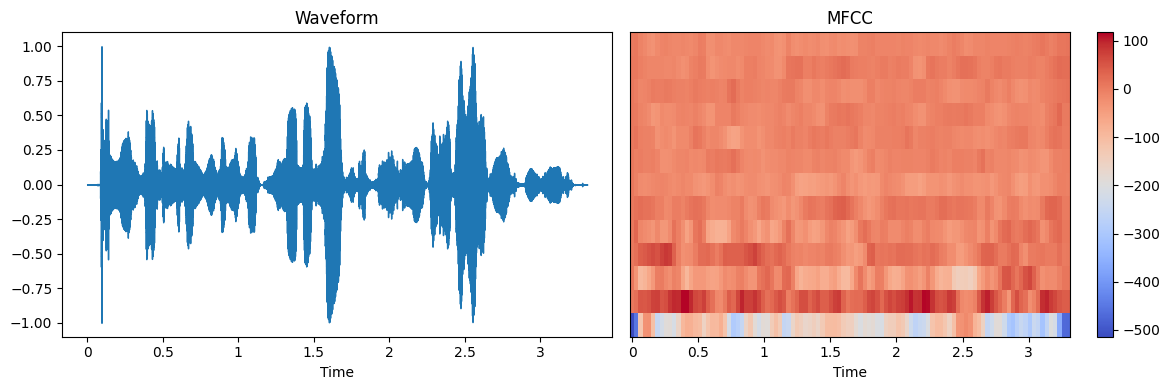


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_03/03-01-05-01-02-01-03.wav
❌ Predicted: disgust | ✅ True: angry


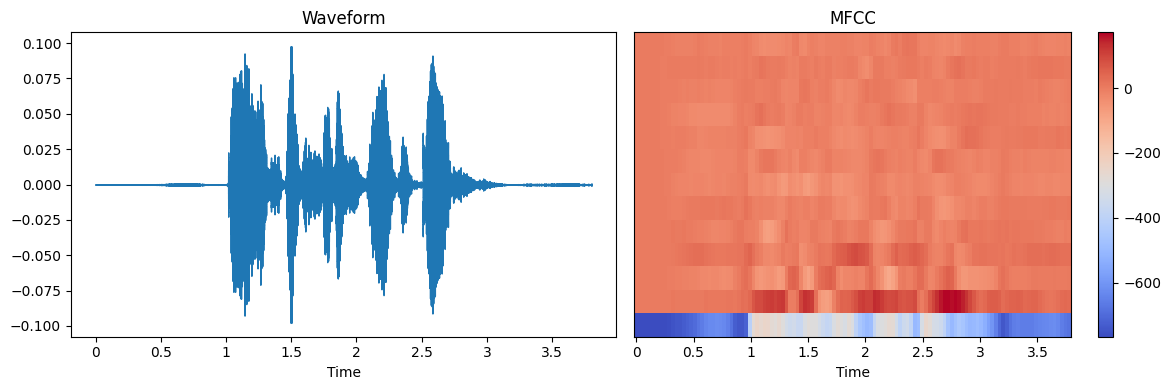


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_08/03-01-04-01-01-01-08.wav
❌ Predicted: fear | ✅ True: sad


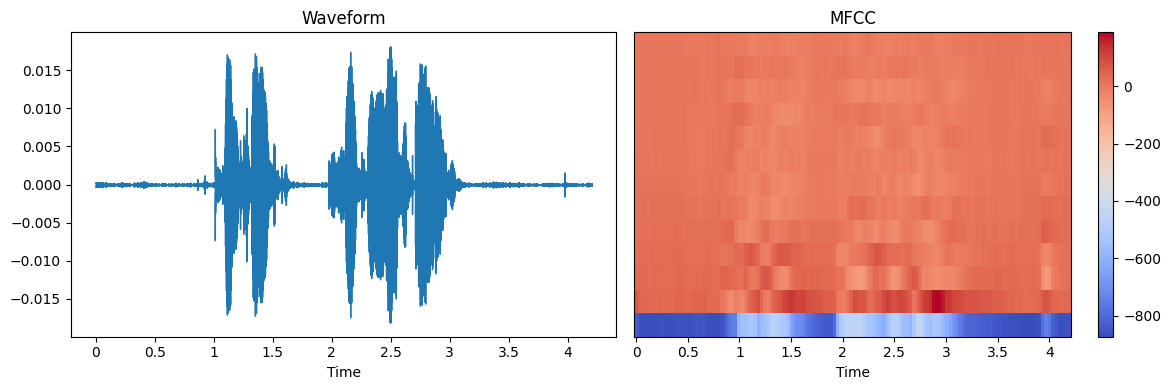


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_12/03-01-04-01-02-02-12.wav
❌ Predicted: fear | ✅ True: sad


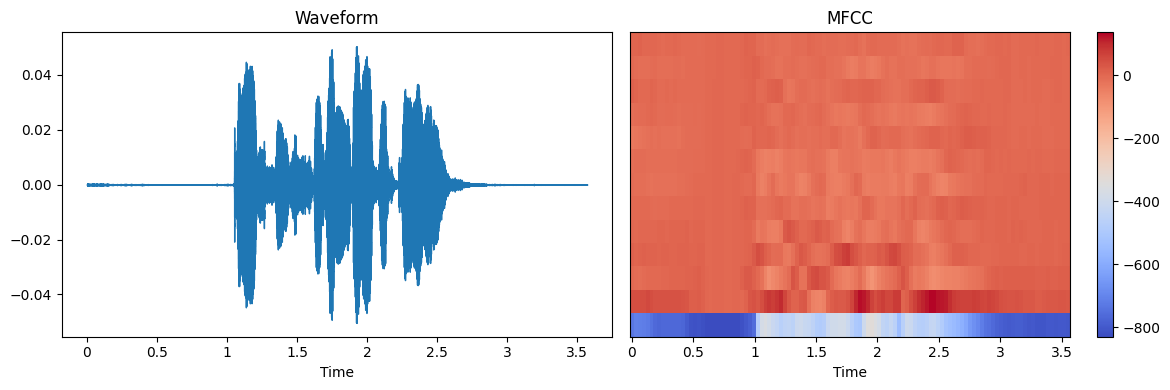


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/OAF_disgust/OAF_hate_disgust.wav
❌ Predicted: angry | ✅ True: disgust


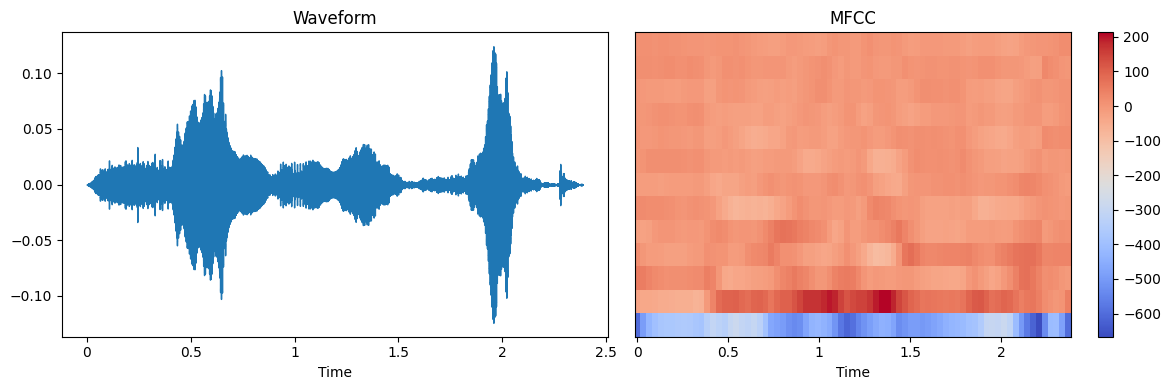


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/15a04Nc.wav
❌ Predicted: disgust | ✅ True: neutral


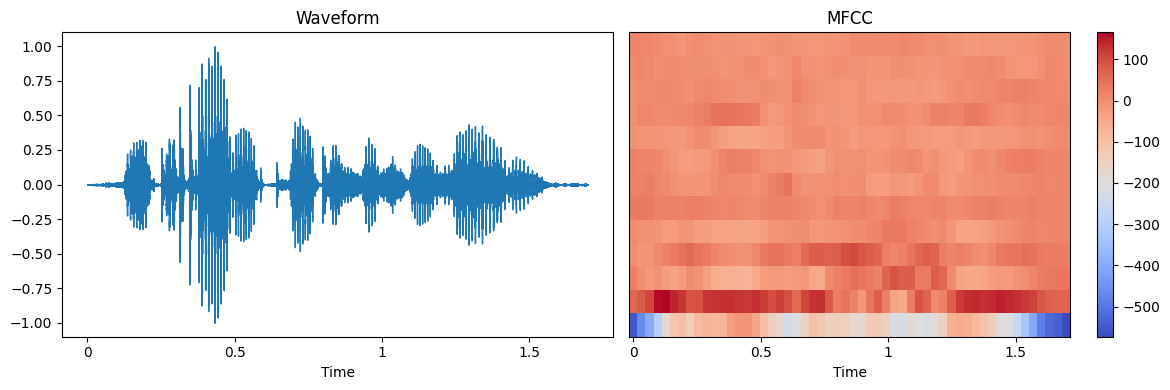


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/OAF_Sad/OAF_late_sad.wav
❌ Predicted: boredom | ✅ True: sad


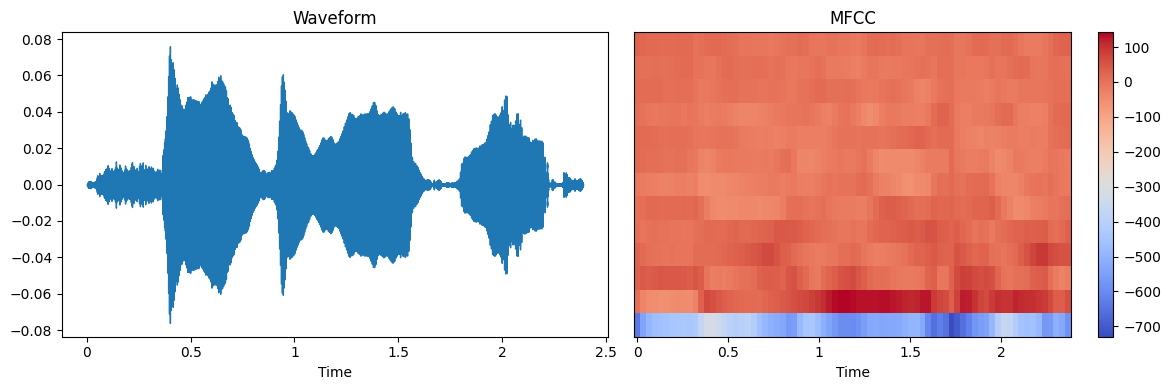


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_sad/YAF_ditch_sad.wav
❌ Predicted: neutral | ✅ True: sad


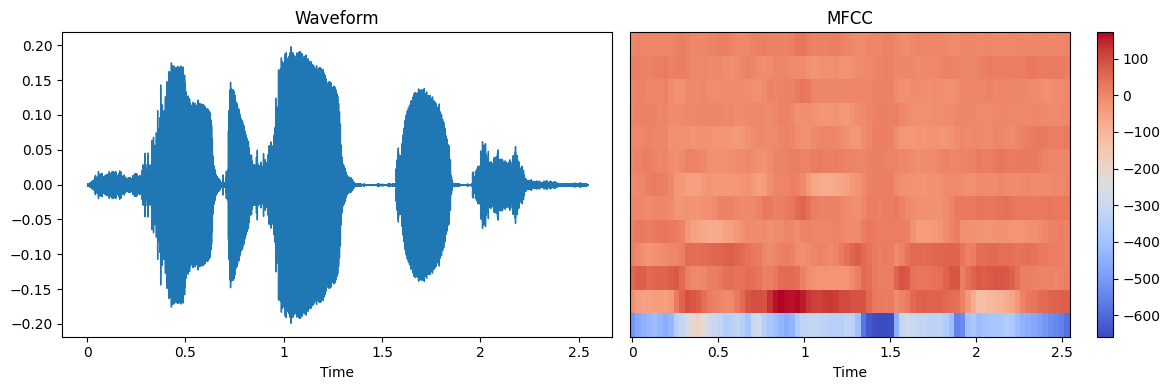


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/OAF_Fear/OAF_walk_fear.wav
❌ Predicted: angry | ✅ True: fear


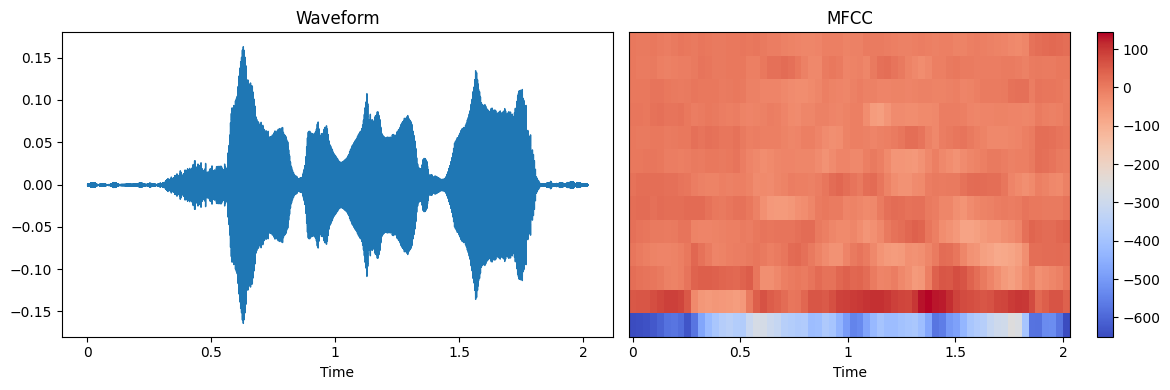


🔉 File: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_neutral/YAF_learn_neutral.wav
❌ Predicted: boredom | ✅ True: neutral


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff31110a940>>
Traceback (most recent call last):
  File "/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


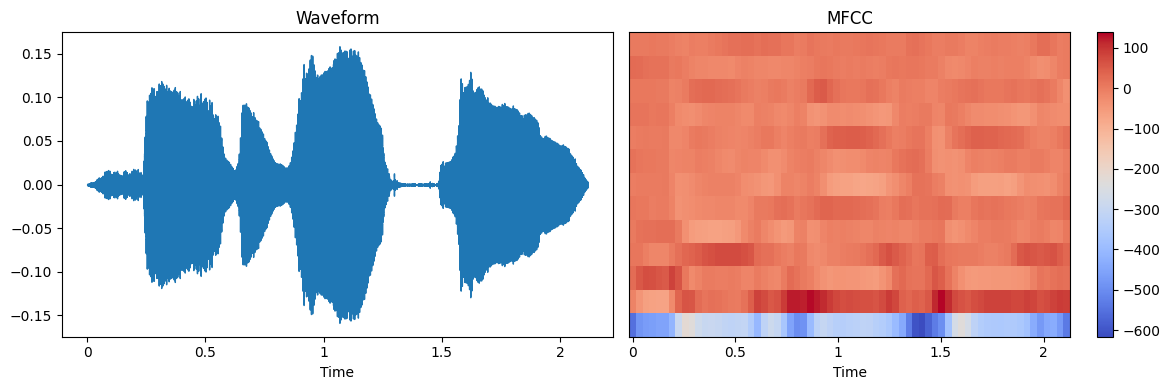

In [ ]:
import os
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt

error_logs = []

# Find misclassified indices
errors = (pred_test != y_test)

for idx in y_test[errors].index:
    true_label = y_test.iloc[idx]
    pred_label = pred_test.iloc[idx]
    filename = filenames_test.iloc[idx]

    # Load audio
    y, sr = librosa.load(filename, sr=16000)

    # Display prediction details
    print(f"\n🔉 File: {filename}")
    print(f"❌ Predicted: {pred_label} | ✅ True: {true_label}")
    display(Audio(y, rate=sr))

    # Plot waveform and MFCCs
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")

    plt.subplot(1, 2, 2)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()

    # Write observation
    observation = input("📝 Your observation (e.g., low volume, hard to distinguish): ")
    error_logs.append({
        "filename": filename,
        "true_label": true_label,
        "predicted_label": pred_label,
        "observation": observation
    })


In [1]:
import pandas as pd

error_df = pd.DataFrame(error_logs)
error_df.to_csv("ser_error_analysis_log.csv", index=False)
print("✅ Error log saved to 'ser_error_analysis_log.csv'")


NameError: name 'error_logs' is not defined

In [61]:
#type(X_short_long)

In [62]:
#X_short_long.to_pickle("X_short_long.pkl")

#X_short_long = pd.read_pickle("X_short_long.pkl")
X_short_long

0       [-429.3894, 54.535877, 1.1364526, 35.0507, -6....
1       [-383.88635, 79.52594, -9.901231, 13.141577, -...
2       [-408.55975, 61.85083, 8.006745, 15.967713, -4...
3       [-431.28967, 48.967884, -1.9902604, 30.844866,...
4       [-411.563, 81.16542, 12.588036, 1.7317361, -4....
                              ...                        
4370    [-542.6259, 49.68073, -22.96277, 9.118455, 1.5...
4371    [-639.61835, 55.00042, -7.707785, 21.59233, 6....
4372    [-711.2978, 67.52659, 12.455447, 23.878843, 8....
4373    [-708.5634, 66.587616, 21.86151, 21.603155, 9....
4374    [-674.5231, 64.75183, 9.010928, 20.544434, 5.8...
Name: filename, Length: 4375, dtype: object

In [63]:
X_short_long.iloc[1]

array([-3.8388635e+02,  7.9525940e+01, -9.9012308e+00,  1.3141577e+01,
       -7.5267143e+00, -1.1980517e+01, -1.2694776e+01, -1.1484585e+01,
       -9.6693830e+00, -2.0187454e+00, -1.1440380e+01,  9.1181517e-01,
       -7.2330384e+00, -3.5318823e+00, -1.6906143e+00, -4.9002471e+00,
       -3.8149133e+00,  9.7506410e-01, -5.8343744e+00,  3.2969887e+00,
       -4.6972675e+00, -3.1907520e+00, -2.8917603e+00, -1.5510011e+00,
       -2.0646787e+00,  1.3339368e+00, -2.9320860e-01,  5.8363476e+00,
        2.8950672e+00,  7.2147999e+00,  2.9976940e+00,  4.0050454e+00,
       -9.6212214e-01, -1.3562789e+00,  3.6650925e+00,  2.6381607e+00,
        4.1473374e+00,  3.5509512e+00,  5.2350718e-01,  4.3905072e+00],
      dtype=float32)

In [64]:
#df['short'], df['X_long'] = zip(*X_short_long)

df

,Unnamed: 0,filename,label,pred,short,X_long
0,0,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[0.3115234375, 0.51611328125, 0.716796875, 0.8...","[0.23075520833333332, 0.22230830036484397, 1.5..."
1,1,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[0.3125, 0.51123046875, 0.71337890625, 0.80712...","[0.18312553510273974, 0.21111824329242648, 2.1..."
2,2,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[0.2890625, 0.47607421875, 0.68896484375, 0.77...","[0.2361339890813253, 0.2612722004030492, 1.337..."
3,3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust,"[0.322265625, 0.52783203125, 0.73828125, 0.823...","[0.231378173828125, 0.21979600605854255, 1.256..."
4,4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,boredom,"[0.3095703125, 0.48974609375, 0.6865234375, 0....","[0.16640878652597402, 0.21791541732036485, 2.0..."
...,...,...,...,...,...,...
4370,1435,/Users/sofiafernandes/.cache/kagglehub/dataset...,happy,NaN,"[0.1298828125, 0.1494140625, 0.189453125, 0.18...","[0.18550749747983872, 0.11980607991758371, 1.2..."
4371,1436,/Users/sofiafernandes/.cache/kagglehub/dataset...,happy,NaN,"[0.037109375, 0.0791015625, 0.1455078125, 0.22...","[0.1641303168402778, 0.09225248495667691, 0.33..."
4372,1437,/Users/sofiafernandes/.cache/kagglehub/dataset...,calm,NaN,"[0.26611328125, 0.3408203125, 0.35791015625, 0...","[0.1797217653508772, 0.11885470900323786, 0.77..."
4373,1438,/Users/sofiafernandes/.cache/kagglehub/dataset...,calm,NaN,"[0.0810546875, 0.18359375, 0.20458984375, 0.20...","[0.17355934633027523, 0.11849726119554534, 1.5..."


In [49]:
len(df.iloc[2]['X_long'])

33396

In [45]:
X_long = pd.DataFrame(df['X_long'].to_list())
X_long

,0,1,2,3,4,5,6,7,8,9,...,111200,111201,111202,111203,111204,111205,111206,111207,111208,111209
0,0.230755,0.222308,1.517038,1.085020,0.015752,0.012829,0.528238,-0.727533,3674.647497,2128.018838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.183126,0.211118,2.162393,3.191537,0.023131,0.017149,0.099836,-1.525708,2941.098623,1976.521717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.236134,0.261272,1.337752,0.154802,0.020692,0.017538,0.451285,-1.083379,3375.097664,2352.227667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.231378,0.219796,1.256072,0.347964,0.015520,0.012657,0.527329,-0.869131,3706.360498,2143.054193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.166409,0.217915,2.081809,2.817522,0.027015,0.025725,1.188484,1.114873,2758.096052,2111.304582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4370,0.185507,0.119806,1.275140,2.634236,0.009187,0.011569,0.990339,-0.260749,2800.452841,1136.066000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4371,0.164130,0.092252,0.332401,-1.258355,0.003857,0.004859,1.035685,0.102410,2663.962450,950.937640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372,0.179722,0.118855,0.776995,-0.466378,0.001464,0.001678,0.906981,-0.438853,2615.057848,1387.330360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4373,0.173559,0.118497,1.542729,3.449801,0.001999,0.002475,1.049541,-0.073469,2407.259709,1227.935914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Converter para matriz 2D
X = pd.DataFrame(np.vstack(X_short_long))
y = df['label'].values

# Split e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
base_pred = clf.predict(X_test)

print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.6525714285714286


Limited duration: 64%

Full duration: 65%

# Train and evaluate with 3 datasets

In [70]:
# concatenate
tess_emo_rav = pd.concat([tess_db, emo_db, rav_db])

all_feats = smile.process_files(tess_emo_rav["filename"])
all_feats

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_date_disgust.wav,0 days,0 days 00:00:02.380765135,33.311512,0.167887,30.233387,33.582432,36.801254,6.567867,37.088375,23.873022,102.139885,78.412605,...,0.015293,-0.013067,0.034128,2.109705,1.724138,0.322500,0.367585,0.232500,0.107558,-33.633442
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_rag_disgust.wav,0 days,0 days 00:00:02.321741624,33.541199,0.221251,30.607704,34.415165,38.339211,7.731506,301.817078,329.956909,47.030148,38.146214,...,0.024138,-0.019726,0.064816,2.597403,1.769912,0.377500,0.378641,0.162500,0.087571,-30.686287
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_raise_disgust.wav,0 days,0 days 00:00:02.646063734,33.721695,0.219033,30.271343,33.172550,39.682961,9.411617,31.068426,20.980042,97.000076,61.183487,...,0.015026,-0.011972,0.027866,2.661597,1.550388,0.405000,0.424882,0.174000,0.142352,-30.999493
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_ditch_disgust.wav,0 days,0 days 00:00:02.542434669,34.361111,0.204392,29.236042,34.488140,37.640064,8.404022,969.197632,1468.279053,60.660587,25.906439,...,-0.006464,-0.011046,0.050418,2.371542,2.016129,0.268000,0.374775,0.204000,0.136176,-33.801414
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_door_disgust.wav,0 days,0 days 00:00:02.448758909,33.536655,0.219005,28.647896,33.393734,39.124413,10.476517,188.472672,132.225250,106.128799,78.476913,...,-0.016488,-0.003887,0.044019,1.639344,1.673640,0.385000,0.414578,0.152000,0.102645,-28.442787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_08/03-01-03-02-02-02-08.wav,0 days,0 days 00:00:03.937270833,38.136395,0.082155,35.621384,39.419216,40.493355,4.871971,164.967346,212.370102,146.544144,104.971375,...,0.007304,0.007272,0.014186,2.040816,0.775194,0.506667,0.091773,0.570000,0.496639,-36.501629
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_08/03-01-03-01-01-02-08.wav,0 days,0 days 00:00:03.436750,34.502087,0.086906,31.821001,34.341667,36.840748,5.019747,30.288549,10.575243,18.359426,12.938098,...,-0.025129,0.007835,0.008716,2.339181,0.890208,0.430000,0.279404,0.666667,0.440025,-44.086678
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_08/03-01-02-02-01-01-08.wav,0 days,0 days 00:00:03.636958333,32.549721,0.145451,32.592190,33.413898,36.421947,3.829758,4.624880,0.000000,18.321108,0.000000,...,-0.008157,0.005465,0.008949,2.209945,1.680672,0.163333,0.119536,0.351429,0.428133,-52.962883


In [ ]:
#tess_emo_rav.to_csv("TESS_EmoDB_RAVDESS.csv")
#all_feats.to_csv("TESS_EmoDB_RAVDESS_features.csv")

In [ ]:
tess_emo_rav pd.read_csv("TESS_EmoDB_RAVDESS.csv")

In [73]:
X = all_feats.values
y = tess_emo_rav.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6, shuffle=True, stratify=y)

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.84      0.86      0.85       216
     boredom       0.74      0.71      0.72        24
        calm       0.71      0.62      0.66        58
     disgust       0.80      0.79      0.79       191
        fear       0.81      0.79      0.80       198
       happy       0.74      0.73      0.74       199
     neutral       0.82      0.88      0.85       173
         sad       0.78      0.78      0.78       196
    surprise       0.68      0.71      0.69        58

    accuracy                           0.79      1313
   macro avg       0.77      0.76      0.77      1313
weighted avg       0.79      0.79      0.79      1313



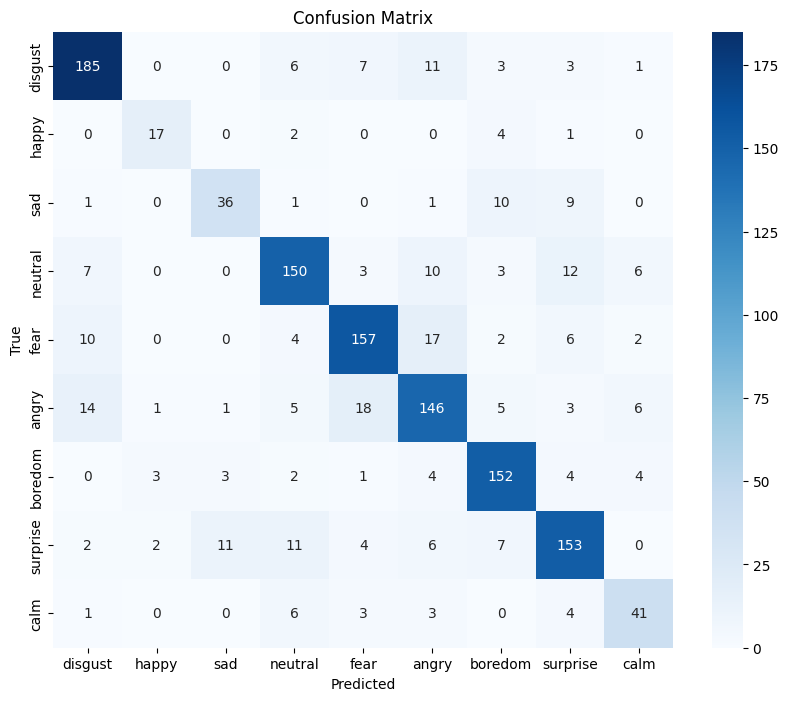

In [78]:
## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
clf12 = svm.SVC(kernel='linear')
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Performance RandomForest with feature scaling
               precision    recall  f1-score   support

       angry       0.85      0.89      0.87       216
     boredom       0.92      0.92      0.92        24
        calm       0.68      0.88      0.77        58
     disgust       0.87      0.80      0.84       191
        fear       0.81      0.83      0.82       198
       happy       0.81      0.75      0.78       199
     neutral       0.94      0.87      0.91       173
         sad       0.84      0.87      0.85       196
    surprise       0.62      0.62      0.62        58

    accuracy                           0.83      1313
   macro avg       0.81      0.83      0.82      1313
weighted avg       0.83      0.83      0.83      1313



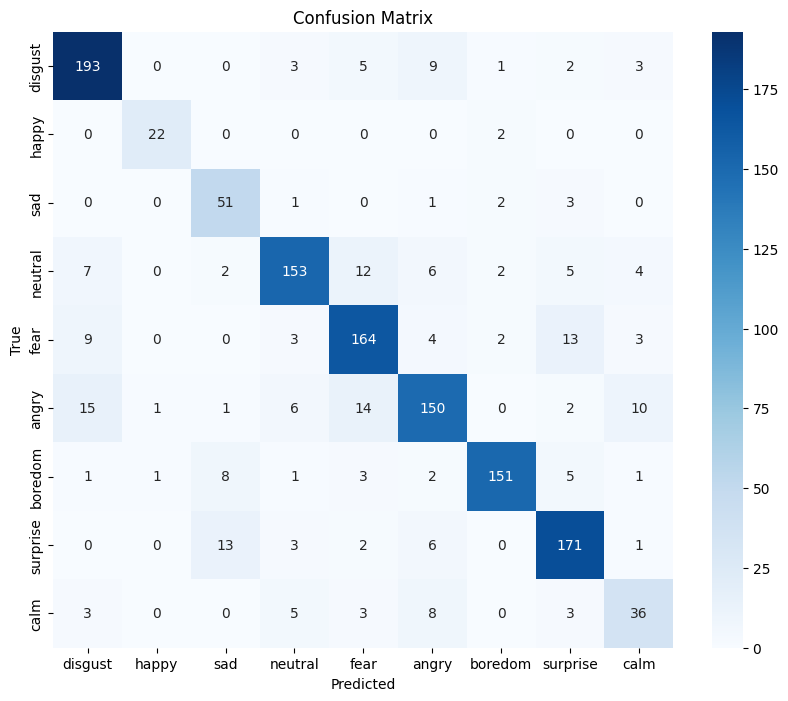

In [79]:
from sklearn.ensemble import RandomForestClassifier
clf12 = RandomForestClassifier()
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance RandomForest with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

       angry       0.89      0.88      0.88       216
     boredom       0.95      0.83      0.89        24
        calm       0.63      0.67      0.65        58
     disgust       0.86      0.85      0.86       191
        fear       0.82      0.81      0.82       198
       happy       0.77      0.80      0.78       199
     neutral       0.87      0.88      0.88       173
         sad       0.83      0.81      0.82       196
    surprise       0.74      0.74      0.74        58

    accuracy                           0.83      1313
   macro avg       0.82      0.81      0.81      1313
weighted avg       0.83      0.83      0.83      1313



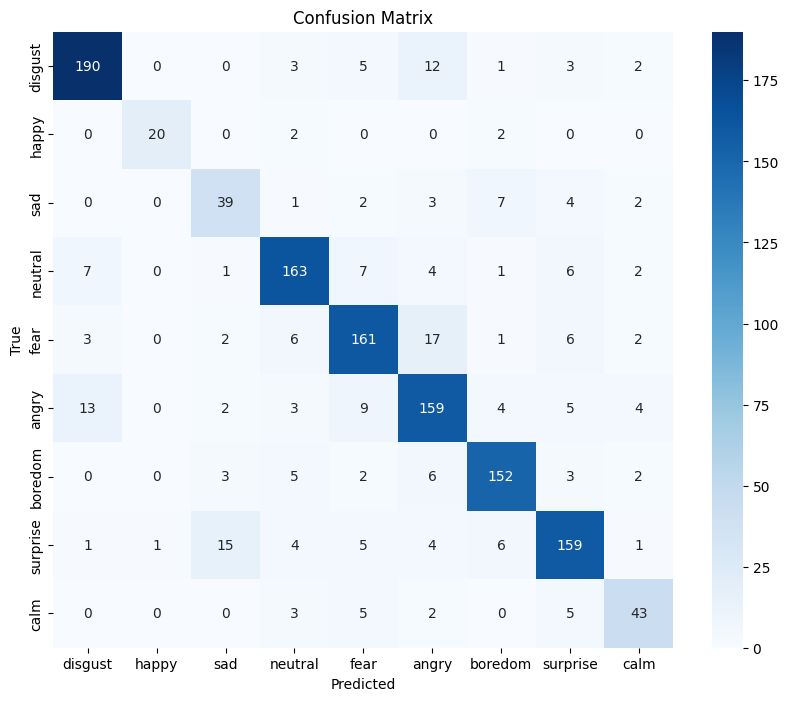

In [97]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Feature scaling is CRUCIAL for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
    alpha=0.0001
)

# Train
mlp.fit(X_train_scaled, y_train)
#mlp.fit(X_train, y_train)

# Evaluate
pred_mlp = mlp.predict(X_test_scaled) #83%
#pred_mlp = mlp.predict(X_test) # 60%
print(classification_report(y_test, pred_mlp))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred_mlp)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(100,), (100,50), (100,50,25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(MLPClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (100, 50),
                                                (100, 50, 25)]})

In [85]:
grid.best_params_

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}

In [95]:
grid.best_score_

0.8327863608738765

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define classifiers and parameter grids
classifiers = {
    'SVM': {
        'model': SVC(),
        'params': {
            'clf__C': [0.1, 1, 10, 100],
            'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__gamma': ['scale', 'auto', 0.1, 1]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance']
        }
    }
}

# Store results
results = []

for name, classifier in classifiers.items():
    # Create pipeline with scaler and classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', classifier['model'])
    ])
    
    # Grid Search with 10-fold CV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=classifier['params'],
        cv=10,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    # Store results
    results.append({
        'model': name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'test_score': grid.score(X_test, y_test)
    })
    
    print(f"\n{name} Best Parameters: {grid.best_params_}")
    print(f"Validation Accuracy: {grid.best_score_:.3f}")
    print(f"Test Accuracy: {grid.score(X_test, y_test):.3f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['model', 'best_score', 'test_score']])

Fitting 10 folds for each of 48 candidates, totalling 480 fits

SVM Best Parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Validation Accuracy: 0.840
Test Accuracy: 0.848
Fitting 10 folds for each of 27 candidates, totalling 270 fits

RandomForest Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Validation Accuracy: 0.840
Test Accuracy: 0.839
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 


LogisticRegression Best Parameters: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Validation Accuracy: 0.795
Test Accuracy: 0.794
Fitting 10 folds for each of 8 candidates, totalling 80 fits

KNN Best Parameters: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Validation Accuracy: 0.793
Test Accuracy: 0.794

Model Comparison:
                model  best_score  test_score
0                 SVM    0.839646    0.847677
1        RandomForest    0.839641    0.839299
2  LogisticRegression    0.794892    0.794364
3                 KNN    0.792617    0.794364


In [99]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from src.select_features import FeatureSelector

# Create pipeline with fixed SVM params and feature selector
pipeline = Pipeline([
    ('selector', FeatureSelector()),
    ('clf', SVC(C=10, gamma='scale', kernel='rbf', random_state=42))  # Fixed SVM params
])

# Define parameter grid for feature selection
param_grid = {
    'selector__algorithm': ['algorithm1', 'algorithm2'],
    'selector__L': [0.7, 0.8, 0.9, 0.95],
    'selector__MS': [0.7, 0.75, 0.8],  # Only used with algorithm2
    'selector__dispersion_measure': ['MM', 'MAD', 'TV', 'AMGM']
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search
grid_search.fit(X_train, y_train)

# Results analysis
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

# Save results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('feature_selection_grid_search_results.csv', index=False)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__disp

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   1.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__di

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, se

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, se

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__

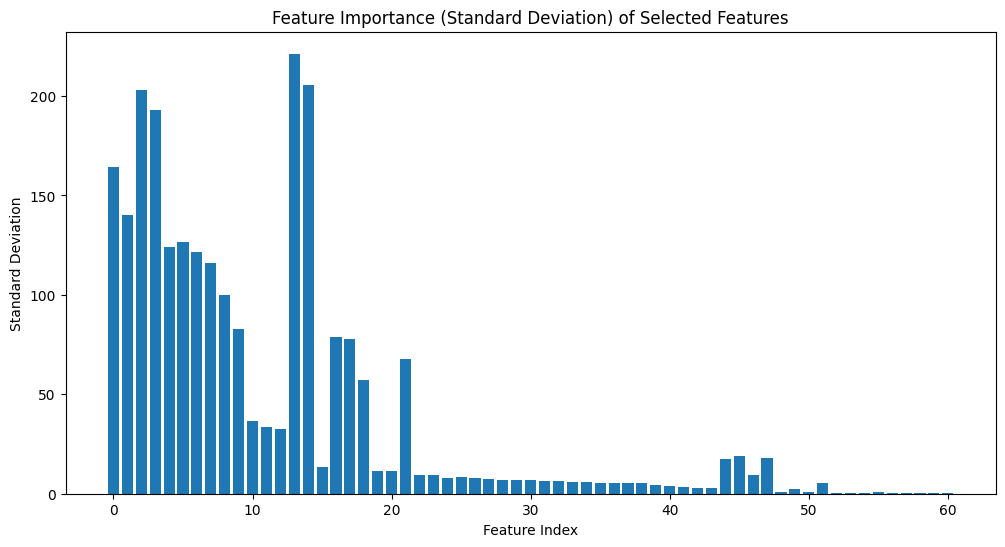

In [100]:

best_selector = grid_search.best_estimator_.named_steps['selector']
plt.figure(figsize=(12, 6))
plt.bar(range(len(best_selector.selected_indices)), 
        X_train.std(axis=0)[best_selector.selected_indices])
plt.title('Feature Importance (Standard Deviation) of Selected Features')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')
plt.show()